# Kaggle Competition: New York City Taxi Trip Duration

The purpose of this analysis is to accurately predict the duration of taxi trips in New York City. This work is for a [Kaggle competition](https://www.kaggle.com/c/nyc-taxi-trip-duration). To make our predictions, we will use a feed-forward neural network using TensorFlow, a RandomForest Regressor, Lightgbm, and Catboost. Random search will be used to find the optimal network architecture and hyperparameter values for each model.

The sections of this analysis are:
- Loading the Data
- Cleaning the Data
- Building the Neural Network
- Training the Neural Network
- Training the Other Models
- Making Predictions
- Summary

In [131]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import tensorflow as tf

from sklearn.ensemble import RandomForestRegressor as RFR
import lightgbm as lgb
from catboost import CatBoostRegressor

from collections import namedtuple
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

import time
import operator
import haversine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

print(tf.__version__)

1.2.1


## Loading the Data

In [132]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [133]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [134]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [135]:
print(train.shape)
print(test.shape)

(1458644, 11)
(625134, 9)


In [136]:
# Check for any duplicates
print(train.duplicated().sum())
print(train.id.duplicated().sum())
print(test.id.duplicated().sum())

0
0
0


In [137]:
# Sanity check to ensure all trips are valid
sum(train.dropoff_datetime < train.pickup_datetime)

0

## Cleaning the Data

In [138]:
# drop feature since it will not be used to make any predictions.
# it is not included in the test dataframe
train = train.drop('dropoff_datetime',1)

In [139]:
# Some of the journeys are very long
train.trip_duration.describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [140]:
# Values are in minutes
print(np.percentile(train.trip_duration, 99)/60)
print(np.percentile(train.trip_duration, 99.5)/60)
print(np.percentile(train.trip_duration, 99.6)/60)
print(np.percentile(train.trip_duration, 99.8)/60)
print(np.percentile(train.trip_duration, 99.85)/60)
print(np.percentile(train.trip_duration, 99.9)/60)
print(np.percentile(train.trip_duration, 99.99)/60)
print(np.percentile(train.trip_duration, 99.999)/60)
print(np.percentile(train.trip_duration, 99.9999)/60)
print(train.trip_duration.max() / 60)

57.3333333333
68.9833333333
73.3833333333
92.5285666667
134.02495
1418.80595
1438.78333333
1439.48333333
35765.9658686
58771.3666667


In [141]:
# Check how many trips remain with each limit
print(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.9)]))
print(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.99)]))
print(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.999)]))

1457185
1458505
1458630


In [142]:
# Remove outliers
train = train[train.trip_duration <= np.percentile(train.trip_duration, 99.999)]

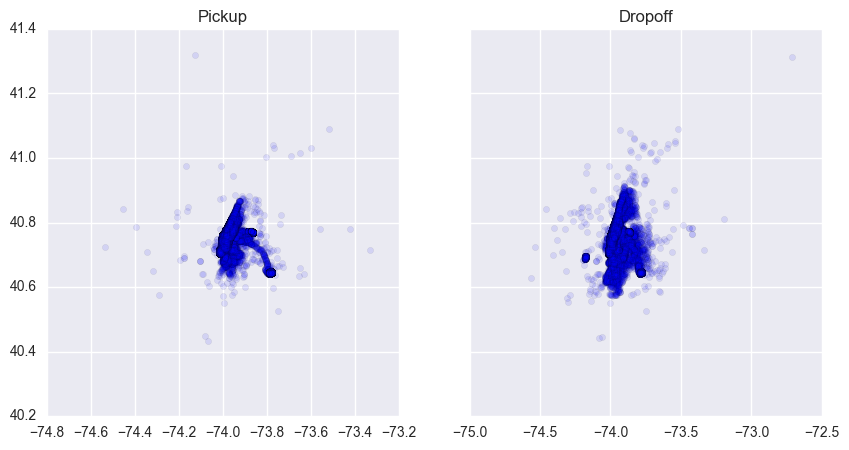

In [143]:
# Plot locations - look for outliers
n = 100000 # number of data points to display

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(train.pickup_longitude[:n], 
            train.pickup_latitude[:n],
            alpha = 0.1)
ax1.set_title('Pickup')
ax2.scatter(train.dropoff_longitude[:n], 
            train.dropoff_latitude[:n],
            alpha = 0.1)
ax2.set_title('Dropoff')

In [144]:
# The values are not too wild, but we'll trim them back a little to be conservative
print(train.pickup_latitude.max())
print(train.pickup_latitude.min())
print(train.pickup_longitude.max())
print(train.pickup_longitude.min())
print()
print(train.dropoff_latitude.max())
print(train.dropoff_latitude.min())
print(train.dropoff_longitude.max())
print(train.dropoff_longitude.min())

51.8810844421
34.3596954346
-61.3355293274
-121.93334198

43.9210281372
32.1811408997
-61.3355293274
-121.933303833


In [145]:
# Find limits of location
max_value = 99.999
min_value = 0.001

max_pickup_lat = np.percentile(train.pickup_latitude, max_value)
min_pickup_lat = np.percentile(train.pickup_latitude, min_value)
max_pickup_long = np.percentile(train.pickup_longitude, max_value)
min_pickup_long = np.percentile(train.pickup_longitude, min_value)

max_dropoff_lat = np.percentile(train.dropoff_latitude, max_value)
min_dropoff_lat = np.percentile(train.dropoff_latitude, min_value)
max_dropoff_long = np.percentile(train.dropoff_longitude, max_value)
min_dropoff_long = np.percentile(train.dropoff_longitude, min_value)

In [146]:
# Remove extreme values
train = train[(train.pickup_latitude <= max_pickup_lat) & (train.pickup_latitude >= min_pickup_lat)]
train = train[(train.pickup_longitude <= max_pickup_long) & (train.pickup_longitude >= min_pickup_long)]

train = train[(train.dropoff_latitude <= max_dropoff_lat) & (train.dropoff_latitude >= min_dropoff_lat)]
train = train[(train.dropoff_longitude <= max_dropoff_long) & (train.dropoff_longitude >= min_dropoff_long)]

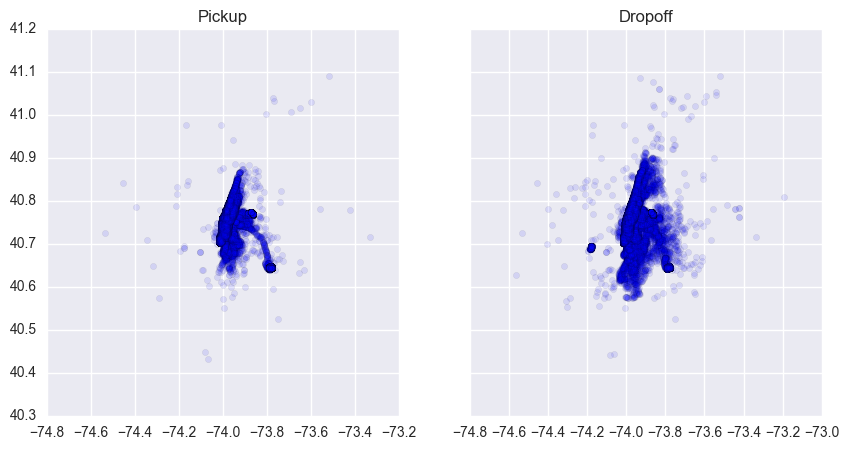

In [147]:
# Replot to see the differences - minimal, but there is some change
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(train.pickup_longitude[:n], 
            train.pickup_latitude[:n],
            alpha = 0.1)
ax1.set_title('Pickup')
ax2.scatter(train.dropoff_longitude[:n], 
            train.dropoff_latitude[:n],
            alpha = 0.1)
ax2.set_title('Dropoff')

In [148]:
# Concatenate the datasets for feature engineering
df = pd.concat([train,test])

In [149]:
df.shape

(2083716, 10)

In [150]:
# Check for null values
# trip_duration nulls to due to them not being present in the test set
df.isnull().sum()

dropoff_latitude           0
dropoff_longitude          0
id                         0
passenger_count            0
pickup_datetime            0
pickup_latitude            0
pickup_longitude           0
store_and_fwd_flag         0
trip_duration         625134
vendor_id                  0
dtype: int64

In [151]:
df.vendor_id.value_counts()

2    1114650
1     969066
Name: vendor_id, dtype: int64

In [153]:
print(train.pickup_datetime.max())
print(train.pickup_datetime.min())
print()
print(test.pickup_datetime.max())
print(test.pickup_datetime.min())
print()
print(df.pickup_datetime.max())
print(df.pickup_datetime.min())

2016-06-30 23:59:39
2016-01-01 00:00:17

2016-06-30 23:59:58
2016-01-01 00:00:22

2016-06-30 23:59:58
2016-01-01 00:00:17


In [154]:
# Convert to datetime
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [155]:
# Calculate what minute in a day the pickup is at
df['pickup_minute_of_the_day'] = df.pickup_datetime.dt.hour*60 + df.pickup_datetime.dt.minute

In [156]:
# Rather than use the standard 24 hours, group the trips into 24 groups that are sorted by KMeans
# This should help 'rush-hour' rides to be in the same groups
kmeans_pickup_time = KMeans(n_clusters=24, random_state=2).fit(df.pickup_minute_of_the_day[:500000].values.reshape(-1,1))

In [157]:
df['kmeans_pickup_time'] = kmeans_pickup_time.predict(df.pickup_minute_of_the_day.values.reshape(-1,1))

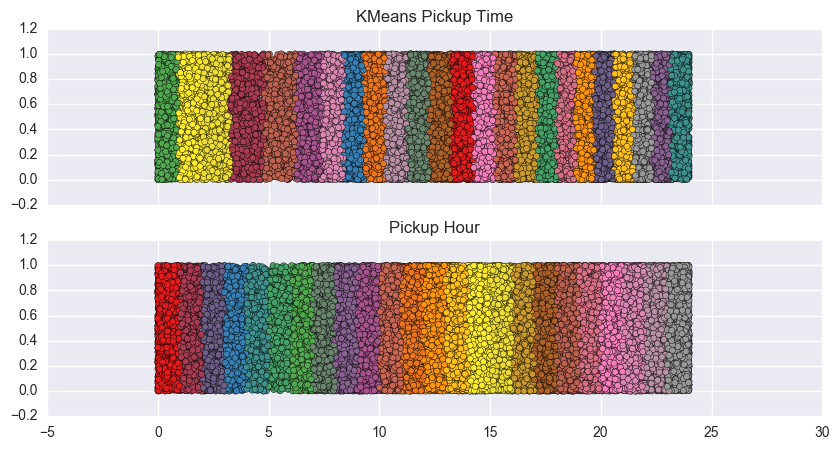

In [158]:
# Compare the distribution of kmeans_pickup_time and the standard 24 hour breakdown
n = 50000 # number of data points to plot
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

ax1.scatter(x = df.pickup_minute_of_the_day[:n]/60, 
            y = np.random.uniform(0,1, n), 
            cmap = 'Set1',
            c = df.kmeans_pickup_time[:n])
ax1.set_title('KMeans Pickup Time')

ax2.scatter(x = df.pickup_minute_of_the_day[:n]/60, 
            y = np.random.uniform(0,1, n), 
            cmap = 'Set1',
            c = df.pickup_datetime.dt.hour[:n])
ax2.set_title('Pickup Hour')

In [159]:
# Load a list of holidays in the US
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

# Load business days
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.DatetimeIndex(start = df.pickup_datetime.min(), 
                                 end = df.pickup_datetime.max(), 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date

In [160]:
# Create features relating to time
df['pickup_month'] = df.pickup_datetime.dt.month
df['pickup_weekday'] = df.pickup_datetime.dt.weekday
df['pickup_is_weekend'] = df.pickup_weekday.map(lambda x: 1 if x >= 5 else 0)
df['pickup_holiday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays)
df['pickup_holiday'] = df.pickup_holiday.map(lambda x: 1 if x == True else 0)

# If day is before or after a holiday
df['pickup_near_holiday'] = (pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) |
                             pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
df['pickup_near_holiday'] = df.pickup_near_holiday.map(lambda x: 1 if x == True else 0)
df['pickup_businessday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(business_days)
df['pickup_businessday'] = df.pickup_businessday.map(lambda x: 1 if x == True else 0)

# Calculates what minute of the week it is
df['week_delta'] = (df.pickup_weekday + ((df.pickup_datetime.dt.hour + 
                                              (df.pickup_datetime.dt.minute / 60.0)) / 24.0))

In [161]:
# Determines number of rides that occur during each specific time
# Should help to determine traffic
ride_counts = df.groupby(['pickup_month', 'pickup_weekday','pickup_holiday','pickup_near_holiday',
            'pickup_businessday','kmeans_pickup_time']).size()
ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0,1)

# Add `ride_counts` to dataframe
df = df.merge(ride_counts, on=['pickup_month',
                          'pickup_weekday',
                          'pickup_holiday',
                          'pickup_near_holiday',
                          'pickup_businessday',
                          'kmeans_pickup_time'], how='left')

In [163]:
# Dont' need this feature any more
df = df.drop('pickup_datetime', 1)

In [164]:
# Group pickup and dropoff locations into 15 groups
kmeans_pickup = KMeans(n_clusters=15, random_state=2).fit(df[['pickup_latitude','pickup_longitude']][:500000])
kmeans_dropoff = KMeans(n_clusters=15, random_state=2).fit(df[['dropoff_latitude','dropoff_longitude']][:500000])

df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude','pickup_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude','dropoff_longitude']])

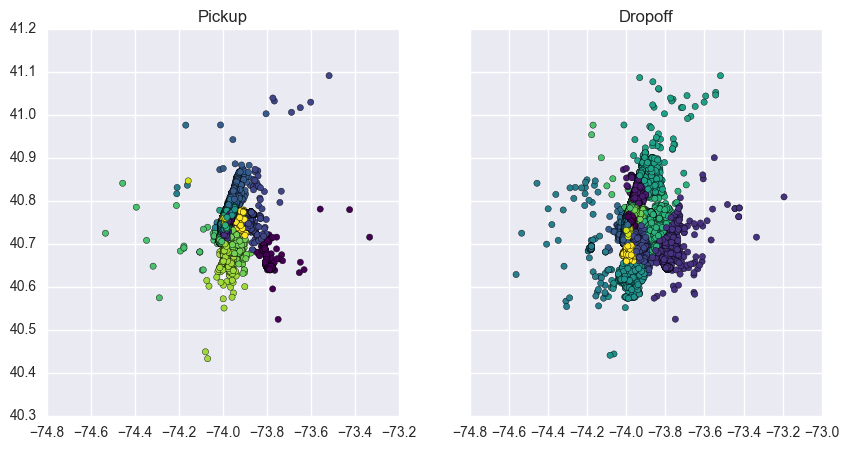

In [166]:
# Plot these 15 groups

n = 100000 # Number of data points to plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_pickup[:n])
ax1.set_title('Pickup')
ax2.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_dropoff[:n])
ax2.set_title('Dropoff')

In [168]:
# Reduce pickup and dropoff locations to one value
pca = PCA(n_components=1)
df['pickup_pca'] = pca.fit_transform(df[['pickup_latitude','pickup_longitude']])
df['dropoff_pca'] = pca.fit_transform(df[['dropoff_latitude','dropoff_longitude']])

In [167]:
# Create distance features
df['distance'] = np.sqrt(np.power(df['dropoff_longitude'] - df['pickup_longitude'], 2) + 
                         np.power(df['dropoff_latitude'] - df['pickup_latitude'], 2))
df['haversine_distance'] = df.apply(lambda r: haversine.haversine((r['pickup_latitude'],r['pickup_longitude']),
                                                                  (r['dropoff_latitude'], r['dropoff_longitude'])), 
                           axis=1)
df['manhattan_distance'] = (abs(df.dropoff_longitude - df.pickup_longitude) +
                            abs(df.dropoff_latitude - df.pickup_latitude))
df['log_distance'] = np.log(df['distance'] + 1)
df['log_haversine_distance'] = np.log(df['haversine_distance'] + 1)
df['log_manhattan_distance'] = np.log(df.manhattan_distance + 1)

In [169]:
def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [170]:
df['bearing'] = calculate_bearing(df.pickup_latitude,
                                  df.pickup_longitude,
                                  df.dropoff_latitude,
                                  df.dropoff_longitude)

In [171]:
df.passenger_count.value_counts()

1    1476947
2     300329
5     111497
3      85581
6      68853
4      40419
0         83
9          3
7          3
8          1
Name: passenger_count, dtype: int64

In [172]:
# Group passenger_count by type of group
df['no_passengers'] = df.passenger_count.map(lambda x: 1 if x == 0 else 0)
df['one_passenger'] = df.passenger_count.map(lambda x: 1 if x == 1 else 0)
df['few_passengers'] = df.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
df['many_passengers'] = df.passenger_count.map(lambda x: 1 if x >= 5 else 0)

In [173]:
df.store_and_fwd_flag = df.store_and_fwd_flag.map(lambda x: 1 if x == 'Y' else 0)

In [174]:
# Create dummy features for these features, then drop these features
dummies = ['kmeans_pickup_time','pickup_month','pickup_weekday','kmeans_pickup','kmeans_dropoff']
for feature in dummies:
    dummy_features = pd.get_dummies(df[feature], prefix=feature)
    for dummy in dummy_features:
        df[dummy] = dummy_features[dummy]
    df = df.drop([feature], 1)

In [175]:
# Check that all features look okay
df.head()

,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id,pickup_minute_of_the_day,pickup_is_weekend,pickup_holiday,pickup_near_holiday,pickup_businessday,week_delta,ride_counts,distance,haversine_distance,manhattan_distance,log_distance,log_haversine_distance,log_manhattan_distance,pickup_pca,dropoff_pca,bearing,no_passengers,one_passenger,few_passengers,many_passengers,kmeans_pickup_time_0,kmeans_pickup_time_1,kmeans_pickup_time_2,kmeans_pickup_time_3,kmeans_pickup_time_4,kmeans_pickup_time_5,kmeans_pickup_time_6,kmeans_pickup_time_7,kmeans_pickup_time_8,kmeans_pickup_time_9,kmeans_pickup_time_10,kmeans_pickup_time_11,kmeans_pickup_time_12,kmeans_pickup_time_13,kmeans_pickup_time_14,kmeans_pickup_time_15,kmeans_pickup_time_16,kmeans_pickup_time_17,kmeans_pickup_time_18,kmeans_pickup_time_19,kmeans_pickup_time_20,kmeans_pickup_time_21,kmeans_pickup_time_22,kmeans_pickup_time_23,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,pickup_weekday_0,pickup_weekday_1,pickup_weekday_2,pickup_weekday_3,pickup_weekday_4,pickup_weekday_5,pickup_weekday_6,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_11,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,40.765602,-73.964630,id2875421,1,40.767937,-73.982155,0,455.0,1,1044,0,0,0,1,0.725000,2115,0.017680,1.498521,0.019859,0.017525,0.915699,0.019665,0.009266,-0.011175,174.333195,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,40.731152,-73.999481,id2377394,1,40.738564,-73.980415,0,663.0,0,43,1,0,0,0,6.029861,2479,0.020456,1.805507,0.026478,0.020249,1.031584,0.026133,0.006485,0.029511,-178.051506,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,40.710087,-74.005333,id3858529,1,40.763939,-73.979027,0,2124.0,1,695,0,0,1,1,1.482639,562,0.059934,6.385098,0.080158,0.058206,1.999464,0.077108,0.005998,0.039204,-179.629721,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,40.706718,-74.012268,id3504673,1,40.719971,-74.010040,0,429.0,1,1172,0,0,0,1,2.813889,2690,0.013438,1.485498,0.015480,0.013349,0.910473,0.015361,0.035431,0.046647,-179.872566,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,40.782520,-73.972923,id2181028,1,40.793209,-73.973053,0,435.0,1,810,1,0,0,0,5.562500,2662,0.010690,1.188588,0.010818,0.010633,0.783257,0.010760,0.001066,-0.006196,179.990812,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [176]:
# Don't need this feature any more
df = df.drop(['id'],1)

In [177]:
# Transform each feature to have a mean of 0 and standard deviation of 1
# Help to train the neural network
for feature in df:
    if feature == 'trip_duration':
        continue
    mean, std = df[feature].mean(), df[feature].std()
    df.loc[:, feature] = (df[feature] - mean)/std

In [178]:
# Check that the transformation was carried out correctly
df.head()

,dropoff_latitude,dropoff_longitude,passenger_count,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_duration,vendor_id,pickup_minute_of_the_day,pickup_is_weekend,pickup_holiday,pickup_near_holiday,pickup_businessday,week_delta,ride_counts,distance,haversine_distance,manhattan_distance,log_distance,log_haversine_distance,log_manhattan_distance,pickup_pca,dropoff_pca,bearing,no_passengers,one_passenger,few_passengers,many_passengers,kmeans_pickup_time_0,kmeans_pickup_time_1,kmeans_pickup_time_2,kmeans_pickup_time_3,kmeans_pickup_time_4,kmeans_pickup_time_5,kmeans_pickup_time_6,kmeans_pickup_time_7,kmeans_pickup_time_8,kmeans_pickup_time_9,kmeans_pickup_time_10,kmeans_pickup_time_11,kmeans_pickup_time_12,kmeans_pickup_time_13,kmeans_pickup_time_14,kmeans_pickup_time_15,kmeans_pickup_time_16,kmeans_pickup_time_17,kmeans_pickup_time_18,kmeans_pickup_time_19,kmeans_pickup_time_20,kmeans_pickup_time_21,kmeans_pickup_time_22,kmeans_pickup_time_23,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,pickup_weekday_0,pickup_weekday_1,pickup_weekday_2,pickup_weekday_3,pickup_weekday_4,pickup_weekday_5,pickup_weekday_6,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_11,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,0.411094,0.174547,-0.505345,0.592172,-0.168330,-0.074414,455.0,0.932411,0.515206,-0.631483,-0.138008,-0.19268,0.660546,-1.493347,-0.021225,-0.407006,-0.477870,-0.455761,-0.424216,-0.540478,-0.483807,0.179862,-0.220659,1.653711,-0.006311,0.640957,-0.507178,-0.307827,-0.227804,-0.140032,-0.234139,-0.213831,-0.20351,4.493516,-0.187212,-0.222419,-0.217711,-0.182372,-0.221339,-0.214977,-0.23721,-0.228784,-0.171726,-0.156131,-0.209006,-0.226716,-0.126445,-0.235599,-0.229371,-0.208938,-0.215522,-0.226366,-0.431735,-0.442037,2.166816,-0.456285,-0.453961,-0.437496,2.604015,-0.402136,-0.410120,-0.419659,-0.42578,-0.422087,-0.393142,-0.152355,-0.408387,-0.327814,-0.167187,-0.134943,-0.248754,-0.33212,-0.374359,2.995119,-0.350370,-0.246731,-0.086028,-0.103978,-0.366194,-0.092205,-0.559904,-0.209533,-0.113264,-0.160103,-0.305592,-0.44229,-0.047323,-0.080627,-0.079433,-0.159237,-0.302740,2.416877,-0.0024,-0.401036,-0.15753
1,-0.616539,-0.520763,-0.505345,-0.430931,-0.134548,-0.074414,663.0,-1.072488,-2.090069,1.583573,-0.138008,-0.19268,-1.513898,1.227029,0.505552,-0.343325,-0.402130,-0.339564,-0.354155,-0.355547,-0.352600,0.125883,0.582728,-1.239000,-0.006311,0.640957,-0.507178,-0.307827,-0.227804,-0.140032,-0.234139,-0.213831,-0.20351,-0.222543,5.341530,-0.222419,-0.217711,-0.182372,-0.221339,-0.214977,-0.23721,-0.228784,-0.171726,-0.156131,-0.209006,-0.226716,-0.126445,-0.235599,-0.229371,-0.208938,-0.215522,-0.226366,-0.431735,-0.442037,-0.461506,-0.456285,-0.453961,2.285734,-0.384022,-0.402136,-0.410120,-0.419659,-0.42578,-0.422087,2.543611,-0.152355,-0.408387,-0.327814,-0.167187,-0.134943,-0.248754,-0.33212,-0.374359,-0.333876,2.854127,-0.246731,-0.086028,-0.103978,-0.366194,-0.092205,-0.559904,-0.209533,-0.113264,-0.160103,-0.305592,-0.44229,-0.047323,-0.080627,-0.079433,-0.159237,-0.302740,-0.413757,-0.0024,2.493543,-0.15753
2,-1.244885,-0.637510,-0.505345,0.452924,-0.107582,-0.074414,2124.0,0.932411,-0.393127,-0.631483,-0.138008,5.18995,0.660546,-1.104824,-2.268708,0.562165,0.727739,0.602873,0.621942,1.189008,0.681334,0.116425,0.774122,-1.251956,-0.006311,0.640957,-0.507178,-0.307827,-0.227804,-0.140032,-0.234139,-0.213831,-0.20351,-0.222543,-0.187212,4.496012,-0.217711,-0.182372,-0.221339,-0.214977,-0.23721,-0.228784,-0.171726,-0.156131,-0.209006,-0.226716,-0.126445,-0.235599,-0.229371

In [179]:
# Return data into a training and testing set
trainFinal = df[:-len(test)]
testFinal = df[-len(test):]

In [180]:
# Check lengths of dataframes
print(len(trainFinal))
print(len(testFinal))
print(len(test))

1458582
625134
625134


In [181]:
# Give trip_duration its own dataframe
# Drop it from the other dataframes
yFinal = pd.DataFrame(trainFinal.trip_duration)
trainFinal = trainFinal.drop('trip_duration',1)
testFinal = testFinal.drop('trip_duration',1)

In [182]:
# Sort data into training and testing sets
x_trainFinal, x_testFinal, y_trainFinal, y_testFinal = train_test_split(trainFinal, 
                                                                        np.log(yFinal+1), 
                                                                        test_size=0.15, 
                                                                        random_state=2)

x_train, x_test, y_train, y_test = train_test_split(x_trainFinal, 
                                                    y_trainFinal, 
                                                    test_size=0.15,
                                                    random_state=2)

## Build the Neural Network

In [183]:
def create_weights_biases(num_layers, n_inputs, multiplier, max_nodes):
    '''Use the inputs to create the weights and biases for a network'''
    
    # Empty dictionaries to store the weights and biases for each layer
    weights = {}
    biases = {}
    
    # Create weights and biases for all layers, but the final layer
    for layer in range(1,num_layers):
        # The first layer needs to use the number of features that are in the dataframe
        if layer == 1:
            weights["h"+str(layer)] = tf.Variable(tf.random_normal([num_features, n_inputs],
                                                                   stddev=np.sqrt(1/num_features)))
            biases["b"+str(layer)] = tf.Variable(tf.random_normal([n_inputs],stddev=0))
            # n_previous keeps track of the number of nodes in the previous layer
            n_previous = n_inputs
            
        else:    
            # To alter number of nodes in each layer, multiply n_previous by multiplier 
            n_current = int(n_previous * multiplier)
            
            # Limit the number of nodes to the maximum amount
            if n_current >= max_nodes:
                n_current = max_nodes
                
            weights["h"+str(layer)] = tf.Variable(tf.random_normal([n_previous, n_current],
                                                                       stddev=np.sqrt(1/n_previous)))
            biases["b"+str(layer)] = tf.Variable(tf.random_normal([n_current],stddev=0))
            n_previous = n_current
            
    # Create weights for the final layer
    n_current = int(n_previous * multiplier)
    if n_current >= max_nodes:
        n_current = max_nodes
            
    # The final layer only has 1 node since this is a regression task
    weights["out"] = tf.Variable(tf.random_normal([n_previous, 1], stddev=np.sqrt(1/n_previous)))
    biases["out"] = tf.Variable(tf.random_normal([1],stddev=0))
                                                    
    return weights, biases

In [184]:
def network(num_layers, n_inputs, weights, biases, rate, is_training, activation_function):
    '''Add the required number of layers to the network'''
    
    for layer in range(1, num_layers):
        if layer == 1:
            current_layer = eval(activation_function + "(tf.matmul(n_inputs, weights['h1']) + biases['b1'])")
            current_layer = tf.nn.dropout(current_layer, 1-rate)
            previous_layer = current_layer
        else:
            current_layer = eval(activation_function + "(tf.matmul(previous_layer,\
            weights['h'+str(layer)]) + biases['b'+str(layer)])")
            current_layer = tf.nn.dropout(current_layer, 1-rate)
            previous_layer = current_layer

    # Output layer with linear activation - because regression
    out_layer = tf.matmul(previous_layer, weights['out']) + biases['out']
    return out_layer

In [185]:
def model_inputs():
    '''Create placeholders for model's inputs '''
    
    inputs = tf.placeholder(tf.float32, [None, None], name='inputs')
    targets = tf.placeholder(tf.float32, [None, 1], name='targets')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    dropout_rate = tf.placeholder(tf.float32, name='dropout_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    return inputs, targets, learning_rate, dropout_rate, is_training

In [186]:
def build_graph(num_layers,n_inputs,weights_multiplier,dropout_rate,learning_rate,max_nodes,activation_function):
    '''Use inputs to build the graph and export the required features for training'''
    
    # Reset the graph to ensure it is ready for training
    tf.reset_default_graph()
    
    # Get the inputs
    inputs, targets, learning_rate, dropout_rate, is_training = model_inputs()
    
    # Get the weights and biases
    weights, biases = create_weights_biases(num_layers, n_inputs, weights_multiplier, max_nodes)
    
    # Construct the network
    preds = network(num_layers, inputs, weights, biases, dropout_rate, is_training, activation_function)    
            
    with tf.name_scope("cost"):
        # Cost function
        cost = tf.sqrt(tf.losses.mean_squared_error(labels=targets, predictions=preds))
        tf.summary.scalar('cost', cost)

    with tf.name_scope("optimze"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Merge all of the summaries
    merged = tf.summary.merge_all()    

    # Export the nodes 
    export_nodes = ['inputs','targets','dropout_rate','is_training','cost','preds','merged',
                    'optimizer','learning_rate']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])

    return graph

## Training the Neural Network

In [187]:
def train(model, epochs, log_string, learning_rate):
    '''Train the Network and return the average RMSE for each iteration of the model'''
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Used to determine when to stop the training early
        testing_loss_summary = []

        iteration = 0 # Keep track of which batch iteration is being trained
        stop_early = 0 # Keep track of how many consective epochs have not achieved a record low RMSE
        stop = 5 # If the batch_loss_testing does not decrease in 5 consecutive epochs, stop training
        per_epoch_training = 2 # Check training progress 2 times per epcoh
        per_epoch_testing = 1 # Check testing progress 1 time per epoch
        
        # Decay learning rate after consective epochs of no improvements
        learning_rate_decay_threshold = np.random.choice([2,3]) 
        original_learning_rate = learning_rate # Keep track of orginial learning rate for each split

        print()
        print("Training Model: {}".format(log_string))

        # Record progress to view with TensorBoard
        train_writer = tf.summary.FileWriter('./logs/1/train/{}'.format(log_string), sess.graph)
        test_writer = tf.summary.FileWriter('./logs/1/test/{}'.format(log_string))
        
        training_check = (len(x_train)//batch_size//per_epoch_training)-1 # Check training progress after this many batches
        testing_check = (len(x_train)//batch_size//per_epoch_testing)-1 # Check testing results after this many batches

        for epoch_i in range(1, epochs+1): 
            batch_loss = 0
            batch_time = 0

            for batch in range(int(len(x_train)/batch_size)):
                batch_x = x_train[batch*batch_size:(1+batch)*batch_size]
                batch_y = y_train[batch*batch_size:(1+batch)*batch_size]

                start_time = time.time()

                summary, loss, _ = sess.run([model.merged,
                                             model.cost, 
                                             model.optimizer], 
                                             {model.inputs: batch_x,
                                              model.targets: batch_y,
                                              model.learning_rate: learning_rate,
                                              model.dropout_rate: dropout_rate,
                                              model.is_training: True})


                batch_loss += loss
                end_time = time.time()
                batch_time += end_time - start_time

                # Record the progress of training
                train_writer.add_summary(summary, iteration)

                iteration += 1

                if batch % training_check == 0 and batch > 0:
                    print('Epoch {:>3}/{} Batch {:>4}/{} - RMSE: {:>6.3f}, Seconds: {:>4.2f}'
                          .format(epoch_i,
                                  epochs, 
                                  batch, 
                                  len(x_train) // batch_size, 
                                  (batch_loss / training_check), 
                                  batch_time))
                    batch_loss = 0
                    batch_time = 0

                #### Testing ####
                if batch % testing_check == 0 and batch > 0:
                    batch_loss_testing = 0
                    batch_time_testing = 0
                    for batch in range(int(len(x_test)/batch_size)):
                        batch_x = x_test[batch*batch_size:(1+batch)*batch_size]
                        batch_y = y_test[batch*batch_size:(1+batch)*batch_size]

                        start_time_testing = time.time()
                        summary, loss = sess.run([model.merged,
                                                  model.cost], 
                                                     {model.inputs: batch_x,
                                                      model.targets: batch_y,
                                                      model.learning_rate: learning_rate,
                                                      model.dropout_rate: 0,
                                                      model.is_training: False})

                        batch_loss_testing += loss
                        end_time_testing = time.time()
                        batch_time_testing += end_time_testing - start_time_testing

                        # Record the progress of testing
                        test_writer.add_summary(summary, iteration)

                    n_batches_testing = batch + 1
                    print('Testing RMSE: {:>6.3f}, Seconds: {:>4.2f}'
                          .format(batch_loss_testing / n_batches_testing, 
                                  batch_time_testing))

                    batch_time_testing = 0

                    # If the batch_loss_testing is at a new minimum, save the model
                    testing_loss_summary.append(batch_loss_testing)
                    if batch_loss_testing <= min(testing_loss_summary):
                        print('New Record!') 
                        lowest_loss_testing = batch_loss_testing/n_batches_testing
                        stop_early = 0 # Reset stop_early if new minimum loss is found
                        checkpoint = "./{}.ckpt".format(log_string)
                        saver = tf.train.Saver()
                        saver.save(sess, checkpoint)

                    else:
                        print("No Improvement.")
                        stop_early += 1 # Increase stop_early if no new minimum loss is found
                        if stop_early % learning_rate_decay_threshold == 0:
                            learning_rate *= learning_rate_decay
                            print("New learning rate = ", learning_rate)
                        elif stop_early == stop:
                            break

            if stop_early == stop:
                print("Stopping training for this iteration.")
                print("Lowest RMSE =", lowest_loss_testing)
                print()
                early_stop = 0
                testing_loss_summary = []
                break
        
    return lowest_loss_testing

In [188]:
# Use random search to choose the values for each iteration

num_iterations = 15
results = {} # Save the log_string and RMSE of each iteration
for i in range(num_iterations):
    # (Randomly) choose the value for each input
    num_features = x_train.shape[1]
    epochs = 50
    learning_rate = np.random.uniform(0.001, 0.1)
    learning_rate_decay = np.random.uniform(0.1,0.5)
    weights_multiplier = np.random.uniform(0.5,2)
    n_inputs = np.random.randint(int(num_features)*0.1,int(num_features)*2)
    num_layers = np.random.choice([2,3,4])
    dropout_rate = np.random.uniform(0,0.3)
    batch_size = np.random.choice([256,512,1024])
    max_nodes = np.random.randint(16, 512)
    activation_function = np.random.choice(['tf.nn.sigmoid',
                                            'tf.nn.relu',
                                            'tf.nn.elu'])

    print("Starting iteration #",i+1)
    log_string = 'LR={},LRD={},WM={},NI={},NL={},DR={},BS={},MN={},AF={}'.format(learning_rate,
                                                                                 learning_rate_decay,
                                                                                 weights_multiplier,
                                                                                 n_inputs,
                                                                                 num_layers,
                                                                                 dropout_rate,
                                                                                 batch_size,
                                                                                 max_nodes,
                                                                                 activation_function) 
    
    model = build_graph(num_layers, n_inputs, weights_multiplier, 
                        dropout_rate,learning_rate,max_nodes,activation_function)
    result = train(model, epochs, log_string, learning_rate)
    results[log_string] = result

Starting iteration # 1

Training Model: LR=0.04602365653553358,LRD=0.1080724493851784,WM=0.5720015924403753,NI=64,NL=2,DR=0.2540759353885638,BS=256,MN=106,AF=tf.nn.sigmoid
Epoch   1/50 Batch 2057/4116 - MSE:  0.540, Seconds: 6.12
Epoch   1/50 Batch 4114/4116 - MSE:  0.482, Seconds: 5.75
Testing MSE:  0.461, Seconds: 1.66
New Record!
Epoch   2/50 Batch 2057/4116 - MSE:  0.476, Seconds: 5.99
Epoch   2/50 Batch 4114/4116 - MSE:  0.475, Seconds: 4.91
Testing MSE:  0.450, Seconds: 0.93
New Record!
Epoch   3/50 Batch 2057/4116 - MSE:  0.472, Seconds: 4.26
Epoch   3/50 Batch 4114/4116 - MSE:  0.472, Seconds: 4.82
Testing MSE:  0.450, Seconds: 1.77
No Improvement.
Epoch   4/50 Batch 2057/4116 - MSE:  0.471, Seconds: 7.21
Epoch   4/50 Batch 4114/4116 - MSE:  0.471, Seconds: 4.35
Testing MSE:  0.448, Seconds: 1.40
New Record!
Epoch   5/50 Batch 2057/4116 - MSE:  0.468, Seconds: 4.76
Epoch   5/50 Batch 4114/4116 - MSE:  0.470, Seconds: 4.22
Testing MSE:  0.444, Seconds: 1.01
New Record!
Epoch   6

In [189]:
def find_inputs(model):
    '''Use the log_string from the model to extract the values for all of the model's inputs'''
    
    learning_rate_start = model.find('LR=') + 3
    learning_rate_end = model.find(',LRD', learning_rate_start)
    learning_rate = float(model[learning_rate_start:learning_rate_end])
    
    learning_rate_decay_start = model.find('LRD=') + 4
    learning_rate_decay_end = model.find(',WM', learning_rate_decay_start)
    learning_rate_decay = float(model[learning_rate_decay_start:learning_rate_decay_end])
    
    weights_multiplier_start = model.find('WM=') + 3
    weights_multiplier_end = model.find(',NI', weights_multiplier_start)
    weights_multiplier = float(model[weights_multiplier_start:weights_multiplier_end])
    
    n_inputs_start = model.find('NI=') + 3
    n_inputs_end = model.find(',NL', n_inputs_start)
    n_inputs = int(model[n_inputs_start:n_inputs_end])
    
    num_layers_start = model.find('NL=') + 3
    num_layers_end = model.find(',DR', num_layers_start)
    num_layers = int(model[num_layers_start:num_layers_end])
    
    dropout_rate_start = model.find('DR=') + 3
    dropout_rate_end = model.find(',BS', dropout_rate_start)
    dropout_rate = float(model[dropout_rate_start:dropout_rate_end])
    
    batch_size_start = model.find('BS=') + 3
    batch_size_end = model.find(',MN', batch_size_start)
    batch_size = int(model[batch_size_start:batch_size_end])
    
    max_nodes_start = model.find('MN=') + 3
    max_nodes_end = model.find(',AF', max_nodes_start)
    max_nodes = int(model[max_nodes_start:max_nodes_end])
    
    activation_function_start = model.find('AF=') + 3
    activation_function = str(model[activation_function_start:])
    
    return (learning_rate, learning_rate_decay, weights_multiplier, n_inputs,
            num_layers, dropout_rate, batch_size, max_nodes, activation_function)

In [190]:
# Sort results by RMSE (lowest - highest)
sorted_results_nn = sorted(results.items(), key=operator.itemgetter(1))

In [191]:
# Create an empty dataframe to contain all of the inputs for each iteration of the model
results_nn = pd.DataFrame(columns=["learning_rate", 
                                   "learning_rate_decay", 
                                   "weights_multiplier", 
                                   "n_inputs",
                                   "num_layers", 
                                   "dropout_rate", 
                                   "batch_size", 
                                   "max_nodes", 
                                   "activation_function"])

for result in sorted_results_nn:
    # Find the input values for each iteration
    learning_rate, learning_rate_decay, weights_multiplier, n_inputs,\
        num_layers, dropout_rate, batch_size, max_nodes, activation_function = find_inputs(result[0])
    
    # Find the Mean Squared Error for each iteration
    RMSE = result[1]
    
    # Create a dataframe with the values above
    new_row = pd.DataFrame([[RMSE,
                             learning_rate, 
                             learning_rate_decay, 
                             weights_multiplier, 
                             n_inputs,
                             num_layers, 
                             dropout_rate, 
                             batch_size, 
                             max_nodes, 
                             activation_function]],
                     columns = ["RMSE",
                                "learning_rate", 
                                "learning_rate_decay", 
                                "weights_multiplier", 
                                "n_inputs",
                                "num_layers", 
                                "dropout_rate", 
                                "batch_size", 
                                "max_nodes", 
                                "activation_function"])
    
    # Append the dataframe as a new row in results_df
    results_nn = results_nn.append(new_row, ignore_index=True)

In [192]:
# Look at the top five iterations
results_nn.head()

,MSE,activation_function,batch_size,dropout_rate,learning_rate,learning_rate_decay,max_nodes,n_inputs,num_layers,weights_multiplier
0,0.399803,tf.nn.elu,512.0,0.025760,0.007395,0.415812,488.0,59.0,4.0,0.616006
1,0.401863,tf.nn.elu,512.0,0.154264,0.007734,0.259850,26.0,97.0,3.0,1.176916
2,0.408745,tf.nn.sigmoid,1024.0,0.260485,0.006501,0.138400,99.0,128.0,3.0,1.936469
3,0.415520,tf.nn.relu,512.0,0.038491,0.016900,0.402882,92.0,172.0,2.0,1.696585
4,0.420680,tf.nn.sigmoid,256.0,0.254076,0.046024,0.108072,106.0,64.0,2.0,0.572002


In [193]:
def make_predictions(data, batch_size):
    '''
    Restore a session to make predictions, then return these predictions
    data: the data that will be used to make predictions.
    '''
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, checkpoint)
        predictions = [] # record the predictions

        for batch in range(int(len(data)/batch_size)):
            batch_x = data[batch*batch_size:(1+batch)*batch_size]

            batch_predictions = sess.run([model.preds],
                                   {model.inputs: batch_x,
                                    model.learning_rate: learning_rate,
                                    model.dropout_rate: 0,
                                    model.is_training: False})

            for prediction in batch_predictions[0]:
                predictions.append(prediction)

        return predictions

In [194]:
initial_preds = {} # stores the RMSE and predictions for x_testFinal
final_preds = {} # store the predictions for testFinal, with x_testFinal's RMSE

iteration = 1 

for model, result in sorted_results_nn:
    checkpoint = str(model) + ".ckpt" 
    
    # Aquire the inputs from the log_string
    _, _, weights_multiplier, n_inputs, num_layers, _, _, max_nodes, activation_function = find_inputs(model)
    
    model = build_graph(num_layers,n_inputs,weights_multiplier,dropout_rate,
                        learning_rate,max_nodes,activation_function)
    
    y_preds_nn = make_predictions(x_testFinal, 659)
    RMSE_nn = np.sqrt(mean_squared_error(y_testFinal, y_preds_nn))
    print("RMSE for iteration #{} is {}.".format(iteration, RMSE_nn))
    print()
    initial_preds[RMSE_nn] = y_preds_nn
    testFinal_preds_nn = make_predictions(testFinal, 258)
    final_preds[RMSE_nn] = [testFinal_preds_nn]
    iteration += 1

INFO:tensorflow:Restoring parameters from LR=0.007395433303257092,LRD=0.4158121883356408,WM=0.616005880636199,NI=59,NL=4,DR=0.02576026135302122,BS=512,MN=488,AF=tf.nn.elu.ckpt
MSE for iteration #1 is 0.40331132300913686.

INFO:tensorflow:Restoring parameters from LR=0.007395433303257092,LRD=0.4158121883356408,WM=0.616005880636199,NI=59,NL=4,DR=0.02576026135302122,BS=512,MN=488,AF=tf.nn.elu.ckpt
INFO:tensorflow:Restoring parameters from LR=0.00773401559414146,LRD=0.25985017760349316,WM=1.176916286698627,NI=97,NL=3,DR=0.1542636936268005,BS=512,MN=26,AF=tf.nn.elu.ckpt
MSE for iteration #2 is 0.40483314623870736.

INFO:tensorflow:Restoring parameters from LR=0.00773401559414146,LRD=0.25985017760349316,WM=1.176916286698627,NI=97,NL=3,DR=0.1542636936268005,BS=512,MN=26,AF=tf.nn.elu.ckpt
INFO:tensorflow:Restoring parameters from LR=0.006501268076836645,LRD=0.13839979094230037,WM=1.9364687834456586,NI=128,NL=3,DR=0.260485311769962,BS=1024,MN=99,AF=tf.nn.sigmoid.ckpt
MSE for iteration #3 is 0.4

## Training the Other Models

In [195]:
# Create an empty dataframe to contain all of the inputs for each iteration of the model
results_rfr = pd.DataFrame(columns=["RMSE",
                                    "n_estimators", 
                                    "max_depth", 
                                    "min_samples_split"])

for i in range(num_iterations):
    # Use random search to choose the inputs' values
    n_estimators = np.random.randint(10,20)
    max_depth = np.random.randint(6,12)
    min_samples_split = np.random.randint(2,50)

    rfr = RFR(n_estimators = n_estimators,
          max_depth = max_depth,
          min_samples_split = min_samples_split,
          verbose = 2,
          random_state = 2)
    
    rfr = rfr.fit(x_train, y_train.values)

    y_preds_rfr = rfr.predict(x_testFinal)
    RMSE_rfr = np.sqrt(mean_squared_error(y_testFinal, y_preds_rfr))
    print("RMSE for iteration #{} is {}.".format(i+1, RMSE_rfr))
    print("NE={}, MD={}, MSS={}".format(n_estimators,
                                        max_depth,
                                        min_samples_split))
    print()
    initial_preds[RMSE_rfr] = y_preds_rfr
    testFinal_preds_rfr = rfr.predict(testFinal)
    final_preds[RMSE_rfr] = [testFinal_preds_rfr]
    
    # Create a dataframe with the values above
    new_row = pd.DataFrame([[RMSE_rfr,
                             n_estimators, 
                             max_depth, 
                             min_samples_split]],
                     columns = ["RMSE",
                                "n_estimators", 
                                "max_depth", 
                                "min_samples_split"])
    
    # Append the dataframe as a new row in results_df
    results_rfr = results_rfr.append(new_row, ignore_index=True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 16


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s


building tree 2 of 16
building tree 3 of 16
building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  5.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s finished


MSE for iteration #1 is 0.4333304964683304.
NE=16, MD=10, MSS=42



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 17


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


building tree 2 of 17
building tree 3 of 17
building tree 4 of 17
building tree 5 of 17
building tree 6 of 17
building tree 7 of 17
building tree 8 of 17
building tree 9 of 17
building tree 10 of 17
building tree 11 of 17
building tree 12 of 17
building tree 13 of 17
building tree 14 of 17
building tree 15 of 17
building tree 16 of 17
building tree 17 of 17


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished


MSE for iteration #2 is 0.46789255811403146.
NE=17, MD=6, MSS=7



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.5s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 12


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s


building tree 2 of 12
building tree 3 of 12
building tree 4 of 12
building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished


MSE for iteration #3 is 0.44014963009259145.
NE=12, MD=9, MSS=24



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 13


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s


building tree 2 of 13
building tree 3 of 13
building tree 4 of 13
building tree 5 of 13
building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished


MSE for iteration #4 is 0.44003106044387597.
NE=13, MD=9, MSS=21



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 16


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


building tree 2 of 16
building tree 3 of 16
building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished


MSE for iteration #5 is 0.4678675272548989.
NE=16, MD=6, MSS=17



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.5s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 19


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


building tree 2 of 19
building tree 3 of 19
building tree 4 of 19
building tree 5 of 19
building tree 6 of 19
building tree 7 of 19
building tree 8 of 19
building tree 9 of 19
building tree 10 of 19
building tree 11 of 19
building tree 12 of 19
building tree 13 of 19
building tree 14 of 19
building tree 15 of 19
building tree 16 of 19
building tree 17 of 19
building tree 18 of 19
building tree 19 of 19


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.6s finished


MSE for iteration #6 is 0.4277820996565559.
NE=19, MD=11, MSS=43



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.3s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 13


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s


building tree 2 of 13
building tree 3 of 13
building tree 4 of 13
building tree 5 of 13
building tree 6 of 13
building tree 7 of 13
building tree 8 of 13
building tree 9 of 13
building tree 10 of 13
building tree 11 of 13
building tree 12 of 13
building tree 13 of 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished


MSE for iteration #7 is 0.4400476755324868.
NE=13, MD=9, MSS=7



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 17


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s


building tree 2 of 17
building tree 3 of 17
building tree 4 of 17
building tree 5 of 17
building tree 6 of 17
building tree 7 of 17
building tree 8 of 17
building tree 9 of 17
building tree 10 of 17
building tree 11 of 17
building tree 12 of 17
building tree 13 of 17
building tree 14 of 17
building tree 15 of 17
building tree 16 of 17
building tree 17 of 17


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished


MSE for iteration #8 is 0.4565979122309317.
NE=17, MD=7, MSS=16



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.6s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 19


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s


building tree 2 of 19
building tree 3 of 19
building tree 4 of 19
building tree 5 of 19
building tree 6 of 19
building tree 7 of 19
building tree 8 of 19
building tree 9 of 19
building tree 10 of 19
building tree 11 of 19
building tree 12 of 19
building tree 13 of 19
building tree 14 of 19
building tree 15 of 19
building tree 16 of 19
building tree 17 of 19
building tree 18 of 19
building tree 19 of 19


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


MSE for iteration #9 is 0.4470489966058965.
NE=19, MD=8, MSS=43



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.8s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 19


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


building tree 2 of 19
building tree 3 of 19
building tree 4 of 19
building tree 5 of 19
building tree 6 of 19
building tree 7 of 19
building tree 8 of 19
building tree 9 of 19
building tree 10 of 19
building tree 11 of 19
building tree 12 of 19
building tree 13 of 19
building tree 14 of 19
building tree 15 of 19
building tree 16 of 19
building tree 17 of 19
building tree 18 of 19
building tree 19 of 19


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


MSE for iteration #10 is 0.4564350776188241.
NE=19, MD=7, MSS=9



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.7s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 19


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


building tree 2 of 19
building tree 3 of 19
building tree 4 of 19
building tree 5 of 19
building tree 6 of 19
building tree 7 of 19
building tree 8 of 19
building tree 9 of 19
building tree 10 of 19
building tree 11 of 19
building tree 12 of 19
building tree 13 of 19
building tree 14 of 19
building tree 15 of 19
building tree 16 of 19
building tree 17 of 19
building tree 18 of 19
building tree 19 of 19


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished


MSE for iteration #11 is 0.46771767527215274.
NE=19, MD=6, MSS=42



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.6s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 17


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s


building tree 2 of 17
building tree 3 of 17
building tree 4 of 17
building tree 5 of 17
building tree 6 of 17
building tree 7 of 17
building tree 8 of 17
building tree 9 of 17
building tree 10 of 17
building tree 11 of 17
building tree 12 of 17
building tree 13 of 17
building tree 14 of 17
building tree 15 of 17
building tree 16 of 17
building tree 17 of 17


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.5s finished


MSE for iteration #12 is 0.42803220668674297.
NE=17, MD=11, MSS=2



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.3s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 12


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


building tree 2 of 12
building tree 3 of 12
building tree 4 of 12
building tree 5 of 12
building tree 6 of 12
building tree 7 of 12
building tree 8 of 12
building tree 9 of 12
building tree 10 of 12
building tree 11 of 12
building tree 12 of 12


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


MSE for iteration #13 is 0.46785383416233045.
NE=12, MD=6, MSS=12



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.8s remaining:    0.0s


building tree 2 of 11
building tree 3 of 11
building tree 4 of 11
building tree 5 of 11
building tree 6 of 11
building tree 7 of 11
building tree 8 of 11
building tree 9 of 11
building tree 10 of 11
building tree 11 of 11


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.3s finished


MSE for iteration #14 is 0.4336218667947708.
NE=11, MD=10, MSS=33



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.6s finished
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


building tree 1 of 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s


building tree 2 of 11
building tree 3 of 11
building tree 4 of 11
building tree 5 of 11
building tree 6 of 11
building tree 7 of 11
building tree 8 of 11
building tree 9 of 11
building tree 10 of 11
building tree 11 of 11


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished


MSE for iteration #15 is 0.440252003565617.
NE=11, MD=9, MSS=10



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.5s finished


In [196]:
# Check the results
results_rfr

,MSE,n_estimators,max_depth,min_samples_split
0,0.433330,16.0,10.0,42.0
1,0.467893,17.0,6.0,7.0
2,0.440150,12.0,9.0,24.0
3,0.440031,13.0,9.0,21.0
4,0.467868,16.0,6.0,17.0
5,0.427782,19.0,11.0,43.0
6,0.440048,13.0,9.0,7.0
7,0.456598,17.0,7.0,16.0
8,0.447049,19.0,8.0,43.0
9,0.456435,19.0,7.0,9.0


In [197]:
# Create an empty dataframe to contain all of the inputs for each iteration of the model
results_lgb = pd.DataFrame(columns=["RMSE",
                                    "num_leaves", 
                                    "max_depth", 
                                    "feature_fraction",
                                    "bagging_fraction",
                                    "bagging_freq",
                                    "learning_rate"])

for i in range(num_iterations):
    
    num_leaves = np.random.randint(100,250)
    max_depth = np.random.randint(6,12)
    feature_fraction = np.random.uniform(0.7,1)
    bagging_fraction = np.random.uniform(0.8,1)
    bagging_freq = np.random.randint(3,10)
    learning_rate = np.random.uniform(0.2,1)
    n_estimators = 100
    early_stopping_rounds = 5

    gbm = lgb.LGBMRegressor(objective = 'regression',
                            boosting_type = 'gbdt',
                            num_leaves = num_leaves,
                            max_depth = max_depth,
                            feature_fraction = feature_fraction,
                            bagging_fraction = bagging_fraction,
                            bagging_freq = bagging_freq,
                            learning_rate = learning_rate,
                            n_estimators = n_estimators)
    
    gbm.fit(x_train.values, y_train.values.ravel(),
            eval_set = [(x_test.values, y_test.values.ravel())],
            eval_metric = 'rmse',
            early_stopping_rounds = early_stopping_rounds)

    y_preds_gbm = gbm.predict(x_testFinal, num_iteration = gbm.best_iteration)
    RMSE_gbm = np.sqrt(mean_squared_error(y_testFinal, y_preds_gbm))
    print("RMSE for iteration #{} is {}.".format(i+1, RMSE_gbm))
    print("NL={}, MD={}, FF={}, BF={}, BQ={}, LR={}, NE={}, ESR={}".format(num_leaves,
                                                                           max_depth,
                                                                           feature_fraction,
                                                                           bagging_fraction,
                                                                           bagging_freq,
                                                                           learning_rate,
                                                                           n_estimators,
                                                                           early_stopping_rounds))
    print()
    initial_preds[RMSE_gbm] = y_preds_gbm
    testFinal_preds_gbm = gbm.predict(testFinal, num_iteration = gbm.best_iteration)
    final_preds[RMSE_gbm] = [testFinal_preds_gbm]
    
    # Create a dataframe with the values above
    new_row = pd.DataFrame([[RMSE_gbm,
                             num_leaves, 
                             max_depth, 
                             feature_fraction,
                             bagging_fraction,
                             bagging_freq,
                             learning_rate]],
                     columns = ["RMSE",
                                "num_leaves", 
                                "max_depth", 
                                "feature_fraction",
                                "bagging_fraction",
                                "bagging_freq",
                                "learning_rate"])
    
    # Append the dataframe as a new row in results_df
    results_lgb = results_lgb.append(new_row, ignore_index=True)

[1]	valid_0's rmse: 0.660052
Train until valid scores didn't improve in 5 rounds.
[2]	valid_0's rmse: 0.575549
[3]	valid_0's rmse: 0.523858
[4]	valid_0's rmse: 0.490996
[5]	valid_0's rmse: 0.471617
[6]	valid_0's rmse: 0.459453
[7]	valid_0's rmse: 0.45128
[8]	valid_0's rmse: 0.444651
[9]	valid_0's rmse: 0.439653
[10]	valid_0's rmse: 0.436549
[11]	valid_0's rmse: 0.434104
[12]	valid_0's rmse: 0.430168
[13]	valid_0's rmse: 0.427609
[14]	valid_0's rmse: 0.425077
[15]	valid_0's rmse: 0.423803
[16]	valid_0's rmse: 0.42177
[17]	valid_0's rmse: 0.420862
[18]	valid_0's rmse: 0.420004
[19]	valid_0's rmse: 0.418263
[20]	valid_0's rmse: 0.417504
[21]	valid_0's rmse: 0.41686
[22]	valid_0's rmse: 0.416183
[23]	valid_0's rmse: 0.414662
[24]	valid_0's rmse: 0.414025
[25]	valid_0's rmse: 0.413606
[26]	valid_0's rmse: 0.413064
[27]	valid_0's rmse: 0.412629
[28]	valid_0's rmse: 0.412115
[29]	valid_0's rmse: 0.411339
[30]	valid_0's rmse: 0.411136
[31]	valid_0's rmse: 0.410765
[32]	valid_0's rmse: 0.410511

In [198]:
results_lgb

,MSE,num_leaves,max_depth,feature_fraction,bagging_fraction,bagging_freq,learning_rate
0,0.398380,197.0,6.0,0.739316,0.878169,4.0,0.283028
1,0.395552,228.0,11.0,0.959279,0.924111,4.0,0.370884
2,0.400016,103.0,8.0,0.938387,0.831444,3.0,0.506323
3,0.401505,199.0,10.0,0.978636,0.929280,9.0,0.547137
4,0.405134,169.0,9.0,0.980138,0.852581,3.0,0.632952
5,0.413967,227.0,10.0,0.752535,0.890151,6.0,0.870420
6,0.412930,116.0,10.0,0.841445,0.931671,3.0,0.949113
7,0.401512,146.0,10.0,0.777239,0.894764,5.0,0.559601
8,0.408313,167.0,10.0,0.737056,0.872173,3.0,0.778940
9,0.401348,225.0,7.0,0.938205,0.874530,9.0,0.554784


In [199]:
# Create an empty dataframe to contain all of the inputs for each iteration of the model
results_cbr = pd.DataFrame(columns=["RMSE",
                                    "iterations", 
                                    "depth", 
                                    "learning_rate",
                                    "rsm"])

for i in range(num_iterations):

    iterations = np.random.randint(50,250)
    depth = np.random.randint(5,12)
    learning_rate = np.random.uniform(0.5,1)
    rsm = np.random.uniform(0.8,1)

    cbr = CatBoostRegressor(iterations = iterations, 
                            depth = depth, 
                            learning_rate = learning_rate,  
                            rsm = rsm,
                            loss_function='RMSE',
                            use_best_model=True)
    
    cbr.fit(x_train, y_train,
            eval_set = (x_test, y_test),
            use_best_model=True)

    y_preds_cbr = cbr.predict(x_testFinal)
    RMSE_cbr = np.sqrt(mean_squared_error(y_testFinal, y_preds_cbr))
    print("RMSE for iteration #{} is {}.".format(i+1, RMSE_cbr))
    print("I={}, D={}, LR={}, RSM={}".format(iterations,
                                             depth,
                                             learning_rate,
                                             rsm))
    print()
    initial_preds[RMSE_cbr] = y_preds_cbr
    testFinal_preds_cbr = cbr.predict(testFinal)
    final_preds[RMSE_cbr] = [testFinal_preds_cbr]
    
    # Create a dataframe with the values above
    new_row = pd.DataFrame([[RMSE_cbr,
                             iterations, 
                             depth, 
                             learning_rate,
                             rsm]],
                     columns = ["RMSE",
                                "iterations", 
                                "depth",
                                "learning_rate",
                                "rsm"])
    
    # Append the dataframe as a new row in results_df
    results_cbr = results_cbr.append(new_row, ignore_index=True)

MSE for iteration #1 is 0.4069024970921378.
I=52, D=7, LR=0.6820795658404888, RSM=0.8174986141454658

MSE for iteration #2 is 0.39951546763787005.
I=166, D=6, LR=0.5350539953832347, RSM=0.845714628284081

MSE for iteration #3 is 0.39815627074708354.
I=219, D=6, LR=0.5727850195534646, RSM=0.8818424210540934

MSE for iteration #4 is 0.3967511358577422.
I=183, D=7, LR=0.51784939160306, RSM=0.8311909772299899

MSE for iteration #5 is 0.399906001477341.
I=159, D=6, LR=0.6921403742663477, RSM=0.917200267520694

MSE for iteration #6 is 0.4010787328864555.
I=217, D=5, LR=0.9482042427604777, RSM=0.9167304360659312

MSE for iteration #7 is 0.40099741219273877.
I=82, D=8, LR=0.9538895227709469, RSM=0.9584941490309039

MSE for iteration #8 is 0.4042627000838441.
I=125, D=5, LR=0.7655241811854878, RSM=0.8687188325195391

MSE for iteration #9 is 0.39980814118247693.
I=243, D=5, LR=0.5017144278713297, RSM=0.8813814743705656

MSE for iteration #10 is 0.3962655940377901.
I=160, D=8, LR=0.53983865010605

In [200]:
results_cbr

,MSE,iterations,depth,learning_rate,rsm
0,0.406902,52.0,7.0,0.682080,0.817499
1,0.399515,166.0,6.0,0.535054,0.845715
2,0.398156,219.0,6.0,0.572785,0.881842
3,0.396751,183.0,7.0,0.517849,0.831191
4,0.399906,159.0,6.0,0.692140,0.917200
5,0.401079,217.0,5.0,0.948204,0.916730
6,0.400997,82.0,8.0,0.953890,0.958494
7,0.404263,125.0,5.0,0.765524,0.868719
8,0.399808,243.0,5.0,0.501714,0.881381
9,0.396266,160.0,8.0,0.539839,0.882853


In [201]:
sorted_initial_RMSE = sorted(initial_preds)
print(sorted_initial_RMSE)

[0.39350144555647537, 0.3940828636576274, 0.39555156541712422, 0.3962655940377901, 0.39675113585774219, 0.39781278634691519, 0.39782344114726659, 0.39815627074708354, 0.3983670529756157, 0.39837960863256611, 0.3990746251087644, 0.39951546763787005, 0.39980814118247693, 0.3998510520748057, 0.39990600147734101, 0.4000159057489503, 0.40058260678143515, 0.40099741219273877, 0.40107873288645551, 0.40134831699672485, 0.40150534520182479, 0.40151153369560516, 0.40290823320811997, 0.40331132300913686, 0.40426270008384407, 0.40483314623870736, 0.4051335080169548, 0.40690249709213783, 0.40831321279659166, 0.4091191747963932, 0.41059248626531036, 0.41293021338656144, 0.41396674140962475, 0.41925126478535368, 0.4257804725814906, 0.42778209965655589, 0.42803220668674297, 0.43044589498962171, 0.43140338238627346, 0.43333049646833038, 0.43362186679477083, 0.44003106044387597, 0.4400476755324868, 0.44014963009259145, 0.440252003565617, 0.44379376641194818, 0.44686148140202786, 0.44704899660589648, 0.4

## Making Predictions

In [208]:
best_models = [] # Records teh RMSE of the models to be used for the final predictions
best_RMSE = 99999999999 # records the best RMSE
best_predictions = np.array([0]*len(x_testFinal)) # records the best predictions for each row
current_model = 1 # Used to equally weight the predictions from each iteration

for model in sorted_initial_RMSE:
    
    predictions = initial_preds[model]
    
    RMSE = np.sqrt(mean_squared_error(y_testFinal, predictions))
    print("RMSE = ", RMSE)
    
    # Equally weight each prediction
    combined_predictions = (best_predictions*(current_model-1) + predictions) / current_model
    
    # Find the RMSE with the new predictions
    new_RMSE = np.sqrt(mean_squared_error(y_testFinal, combined_predictions))
    print("New RMSE = ", new_RMSE)
    
    if new_RMSE <= best_RMSE:
        best_predictions = combined_predictions
        best_RMSE = new_RMSE
        best_models.append(model)
        current_model += 1
        print("Improvement!")
        print()
    else:
        print("No improvement.")
        print()

MSE =  0.393501445556
New MSE =  0.393501445556
Improvement!

MSE =  0.394082863658
New MSE =  0.388265778811
Improvement!

MSE =  0.395551565417
New MSE =  0.387246334564
Improvement!

MSE =  0.396265594038
New MSE =  0.387231279601
Improvement!

MSE =  0.396751135858
New MSE =  0.387577546951
No improvement.

MSE =  0.397812786347
New MSE =  0.38760270454
No improvement.

MSE =  0.397823441147
New MSE =  0.387020840033
Improvement!

MSE =  0.398156270747
New MSE =  0.38755490201
No improvement.

MSE =  0.398367052976
New MSE =  0.387403861494
No improvement.

MSE =  0.398379608633
New MSE =  0.387591968851
No improvement.

MSE =  0.399074625109
New MSE =  0.387665547625
No improvement.

MSE =  0.399515467638
New MSE =  0.387633639428
No improvement.

MSE =  0.399808141182
New MSE =  0.387752411304
No improvement.

MSE =  0.399851052075
New MSE =  0.38686516921
Improvement!

MSE =  0.399906001477
New MSE =  0.387349613359
No improvement.

MSE =  0.400015905749
New MSE =  0.38687223100

In [209]:
best_predictions = pd.DataFrame([0]*len(testFinal)) # Records the predictions to be used for submission to Kaggle
current_model = 1

for model in best_models:
    print(model)
    predictions = final_preds[model][0]
    predictions = pd.DataFrame(np.exp(predictions)-1)
    
    combined_predictions = (best_predictions*(current_model-1) + predictions) / current_model
    best_predictions = combined_predictions
    current_model += 1

0.393501445556
0.394082863658
0.395551565417
0.396265594038
0.397823441147
0.399851052075
0.400582606781
0.401505345202
0.401511533696
0.402908233208


In [210]:
# Prepare the dataframe for submitting to Kaggle
best_predictions['id'] = test.id
best_predictions['trip_duration'] = best_predictions[0]
best_predictions = best_predictions.drop([0],1)

best_predictions.to_csv("submission_combined.csv", index=False)

In [211]:
# Preview the predictions
best_predictions.head()

,id,trip_duration
0,id3004672,879.364546
1,id3505355,556.329691
2,id1217141,436.648136
3,id2150126,948.602002
4,id1598245,373.248729


In [212]:
# Compare the predicted values with the training values - the distribution should be similar
best_predictions.trip_duration.describe()

count    625134.000000
mean        811.202772
std         587.226491
min           6.057386
25%         407.560847
50%         655.911144
75%        1038.302924
max        5917.466847
Name: trip_duration, dtype: float64

In [207]:
yFinal.describe()

,trip_duration
count,1.458582e+06
mean,9.522040e+02
std,3.163415e+03
min,1.000000e+00
25%,3.970000e+02
50%,6.620000e+02
75%,1.075000e+03
max,8.636900e+04


## Summary

This ensemble approach with random search has worked rather well. Currently, I am ranked in the top 13% of this competition. Creating numerous features and fine-tuning the range for the random searches were critical to the success of this work. 